# Bayesian analysis of the empirical saturation point

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import matplotlib as mpb
from scipy.stats import invwishart
from matplotlib.patches import Rectangle
import pymc3 as pm
from plot_helpers import *
import seaborn as sns
import re
import glob

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Empirical constraints: status quo

### Empirical box used in many-body theory

In [8]:
def plot_saturation_box(ax=None, filenames=None, plot_scatter=True, print_result=True,
                        facecolor='lightgray', edgecolor='gray', alpha=0.4, zorder=9, **kwargs):
    # read data (support for data from multiple files)
    filenames = filenames if filenames else ("satpoints_brown_schwenk.csv", "satpoints_kortelainen.csv")
    data = pd.DataFrame()
    for file in filenames:
        data_read = pd.read_csv(f"data/{file}", comment="#", dtype={"Label":str, "rho0":np.float64, "E/A": np.float64})
        data_read["origin"] = re.search("satpoints_(\w*).csv", file).group(1)
        data = pd.concat([data, data_read], copy=False, ignore_index=True)

    # compute constraint
    result = dict()
    for dim in ("rho0", "E/A"):
        df = data[dim]
        uncert = (df.max() - df.min())/2.
        central = df.min() + uncert
        result[dim] = (central, uncert)

    # print results if requested
    if print_result:
        print("Empirical saturation point from Drischler et al. (2016):")
        print(f"n0 = {result['rho0'][0]:.3f} +/- {result['rho0'][1]:.3f} fm^(-3)")
        print(f"E0/A = {result['E/A'][0]:.1f} +/- {result['E/A'][1]:.1f} MeV")

    # plot constraint
    if ax is None:
        ax = plt.gca()
    left, right = result['rho0'][0] - result['rho0'][1], result['rho0'][0] + result['rho0'][1]
    down = result['E/A'][0] - result['E/A'][1]
    rect = Rectangle(
        (left, down), width=2*result['rho0'][1], height=2*result['E/A'][1], label=r"Drischler \textit{et al.}",
        facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, zorder=zorder, **kwargs
    )
    ax.add_patch(rect)

    # plot scatter
    if plot_scatter:
        mask = data['origin'] == "kortelainen"
        marker_size = 8
        ax.scatter(data[mask]["rho0"], data[mask]["E/A"], color=colors[0], s=marker_size, label=r"Kortelainen \textit{et al.}")
        ax.scatter(data[~mask]["rho0"], data[~mask]["E/A"], color=colors[1], s=marker_size, label="Brown \& Schwenk")
    return data, result

The results should match the results from the Drischler et al. paper (2016):
$$
n^\mathrm{emp}_0 = (0.164 \pm 0.007) \, \mathrm{fm}^{−3} \quad E^\mathrm{emp}/A \approx −(15.9 \pm 0.4) \mathrm{MeV}
$$
Skyrme energy-density functionals based on properties of nuclei and nuclear matter can be used to empirically constrain the saturation point [50–52]. Table 7 of Ref. [50] summarizes 16 selected functionals, which reproduce well selected properties of nuclear matter. Six more are excluded because of unreasonable behavior for large densities [50] or being unstable for finite nuclei. The remaining ten are listed in Table 1 of Ref. [52]. Our empirical saturation range is determined based on these functionals plus those of Ref. [53] (SLy4, UNEDF0, UNEDF1, and UNEDF2). As a result we obtain the ranges nemp0 = (0.164 ± 0.007) fm−3 and boxes in Figs. 4 (for x = 0.5) and 5. Eemp/A ?−(15.9 ± 0.4) MeV, whic

Empirical saturation point from Drischler et al. (2016):
n0 = 0.164 +/- 0.007 fm^(-3)
E0/A = -15.9 +/- 0.4 MeV


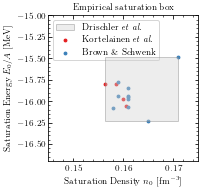

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
data = plot_saturation_box(ax=ax)
ax.set_xlim(0.145, 0.175)
ax.set_ylim(-16.7, -15.)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend()
ax.set_title("Empirical saturation box")
fig.savefig("empirical_sat_box.pdf")

### Relativistic Mean Field (Dutra et al.)

In [10]:
def plot_rmf_dutra(ax=None, filenames=None):
    # read data (support for data from multiple files)
    filenames = filenames if filenames else ("satpoints_rmf_dutra_2014.csv",)
    data = pd.DataFrame()
    for file in filenames:
        data_read = pd.read_csv(f"data/{file}", comment="#", dtype={"Label":str, "rho0":np.float64, "E/A": np.float64})
        data_read["origin"] = re.search("satpoints_(\w*).csv", file).group(1)
        data = pd.concat([data, data_read], copy=False, ignore_index=True)
    ax.scatter(data["rho0"], data["E/A"], color=colors[-5], s=8, label=r"Dutra \textit{et al.}")
    return data

### Relativisitc energy functionals

In [11]:
def plot_saturation_piekarewicz(ax=None, n_std=2, alpha=0.4, **kwargs):
    # read files
    files = sorted(glob.glob("data/Piekarewicz/*/CovEllipse.com"))
    data = []; labels = []
    for file in files:
        labels.append(re.search("(\w+)/Cov", file).group(1))
        data.append(open(file, 'r').readlines()[3].strip().split(","))
    data = pd.DataFrame(data, columns=("rho0", "E/A", "sigma rho0", "sigma E/A", "rho"), dtype=np.float64)
    data["label"] = labels

    # determine mean vector and covariance matrix from data set
    def get_mean_cov_rmf(row):
        mean = np.array([row["rho0"], row["E/A"]])
        cov_offdiag = row["sigma rho0"]*row["sigma E/A"]*row["rho"]
        cov = np.array([[row["sigma rho0"]**2, cov_offdiag], [cov_offdiag, row["sigma E/A"]**2]])
        return mean, cov

    # plot the constraints
    if ax is None:
            ax = plt.gca()
    for index, row in data.iterrows():
        mean, cov = get_mean_cov_rmf(row)
        confidence_ellipse_mean_cov(mean=mean, cov=cov, n_std=n_std, ax=ax,
                                    facecolor=colors[index], alpha=alpha, label=row["label"] + f" ({n_std:d}$\sigma$)", **kwargs)
    return data

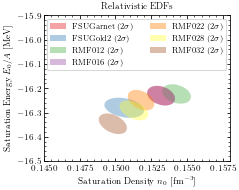

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 6.8*cm))
plot_saturation_piekarewicz(ax=ax)
ax.set_xlim(0.145, 0.158)
ax.set_ylim(-16.5, -15.9)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=2, prop={'size': 8})
ax.set_title("Relativistic EDFs")
fig.savefig("satpoints_rmf_piekarewicz.pdf")

### Nonrelativistic EDFs

In [95]:
def plot_saturation_schunck(ax=None, levels=86, fill=False, num_sample=None):
    # Number of contour levels or values to draw contours at.
    # A vector argument must have increasing values in [0, 1].
    # Levels correspond to iso-proportions of the density:
    # e.g., 20% of the probability mass will lie below the contour drawn for 0.2. Only relevant with bivariate data.
    # Note that 39% corresponds to 1sigma, and 86% to 2sigma regions
    levels = 1. - np.atleast_1d(levels)/100.
    if fill:
        levels = np.append(levels, 1.)
    data = pd.DataFrame()
    num_sample = range(1,num_sample+1) if num_sample else range(1,3+1)
    for isample in num_sample:
        data_read = pd.read_csv(f"data/Schunck/samples{isample}.csv", comment="#", names=("rho0", "E/A"), skiprows=0)
        sns.kdeplot(ax=ax, x=data_read["rho0"], y=data_read["E/A"], fill=fill, levels=levels,
                    label=f"sample set {isample}" + f" ({(1-levels[0])*100:.0f}\%)",
                    legend=False, color=colors[-isample])  # TODO: sns.kdeplot() seems to have issues with displaying the handles in legends
        data_read["sample no."] = isample
        data = pd.concat([data, data_read])
    return data

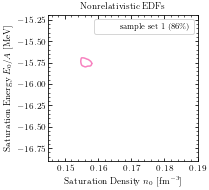

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
data = plot_saturation_schunck(ax=ax, num_sample=1, fill=False)
ax.set_xlim(0.145, 0.19)
ax.set_ylim(-16.9, -15.2)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=1, prop={'size': 8})
ax.set_title("Nonrelativistic EDFs")
fig.savefig("satpoints_schunck.pdf")

### Summary Figure

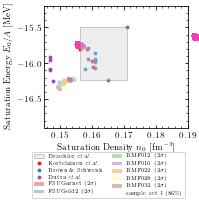

In [97]:
def plot_dft_constraints():
    fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 1.*6.8*cm), constrained_layout=True)
    plot_saturation_box(ax=ax, print_result=False)
    plot_rmf_dutra(ax=ax)
    plot_saturation_piekarewicz(ax=ax)
    plot_saturation_schunck(ax=ax, num_sample=1, fill=True)
    # ax.set_xlim(0.145, 0.19)
    # ax.set_ylim(-16.9, -15.2)
    ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
    ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
    ax.legend(bbox_to_anchor=(0.45, -0.6), loc='lower center', ncol=2, prop={'size': 5})
    #ax.set_title("Summary of DFT constraints")
    fig.savefig("satpoints_summary.pdf")
    return fig, ax
fig, ax = plot_dft_constraints()

## Bayesian inference of the Coester Band

We perform a Bayesian regression with the (generic) linear model:
\begin{equation}
y_i(x_i) =\beta_0 + \beta_1 x_i +\epsilon_i ,
\end{equation}
where $\lbrace (x_i, y_i) \rbrace_i$ corresponds to the data set, \ie, the predicted saturation densities and energies per particle, respectively, and $\beta_0$ and $\beta_1$ are the to-be-determined parameters.
We model the uncertainties in the predicted energies per particle using a normally distributed noise term, $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ with the to-be-estimated standard deviation $\sigma$.
Note that these uncertainties are modeled as random draws from a single distribution for each data point.

In [57]:
data_eft_full = pd.read_csv("data/satpoint_predicted.csv")
data_eft_curated = data_eft_full[((data_eft_full["method"]=="MBPT") & (data_eft_full["mbpt_order"]==4)) | (data_eft_full["method"]=="MBPT*")]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 48 seconds.


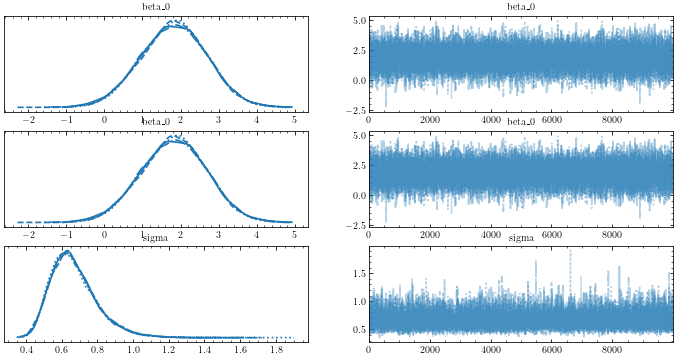

In [58]:
with pm.Model() as model:
    x_data = pm.Data("x_data", data_eft_curated["n0"])
    beta_0 = pm.Normal("beta_0", mu=1.5, sd=1)
    beta_1 = pm.Normal("beta_1", mu=-100, sd=50)
    sigma = pm.InverseGamma("sigma", alpha=6, beta=5)
    y = pm.Normal('y', mu=beta_0 + beta_1 * x_data, sd=sigma, observed=data_eft_curated["En0"])

    step = pm.NUTS(target_accept=.95)
    trace = pm.sample(draws=10000, tune=2000, step=step, return_inferencedata=False) # , nuts_kwargs=dict(target_accept=0.90))
    pm.plot_trace(trace, ["beta_0", "beta_0", "sigma"])
    plt.show()
    #pm.display(pm.summary(trace, round_to=2))

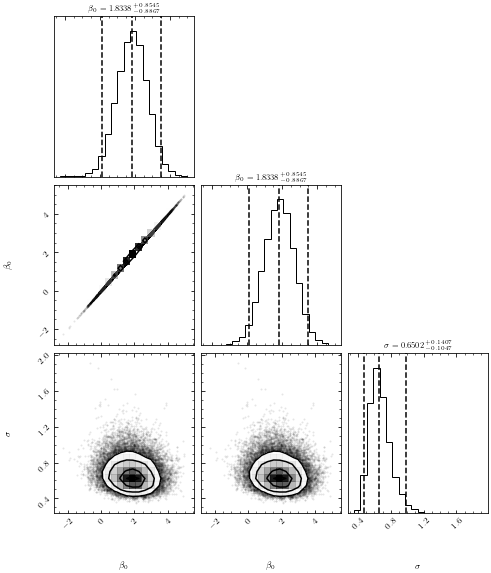

In [59]:
with model:
    names = ["beta_0", "beta_0", "sigma"]
    labels = [r"$\beta_0$", r"$\beta_0$", r"$\sigma$"]
    figure = mpb.figure.Figure(figsize=(1.05*17.88*cm, 2.5*8.6*cm))
    corner.corner(trace, var_names=names, labels=labels, # truths={**physical_point, "error": sigma},
                  quantiles=(0.025, 0.5, 0.975),
                  title_quantiles=(0.025, 0.5, 0.975),
                  show_titles=True, title_fmt=".4f", title_kwargs={"fontsize": 8}, fig=figure)
    figure.savefig("corner_coester_params.pdf")
figure

In [98]:
x_validate = np.linspace(0.14, 0.20, 10)
with model:
    pm.set_data({"x_data": x_validate}, model=model)
    posterior_predict = pm.sample_posterior_predictive(trace)

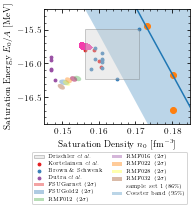

In [108]:
fig, ax = plot_dft_constraints()
level=95 # in percent
lower = np.quantile(posterior_predict["y"], q=0.5-level/200, axis=0)
upper = np.quantile(posterior_predict["y"], q=0.5+level/200, axis=0)
ax.fill_between(x_validate, lower, upper, alpha=0.3, label=f"Coester band ({level:.0f}\%)")
ax.scatter(data_eft_curated["n0"], data_eft_curated["En0"])
ax.plot(x_validate, np.median(posterior_predict["y"], axis=0)) #, label="Coester band")
ax.legend(bbox_to_anchor=(0.45, -0.72), loc='lower center', ncol=2, prop={'size': 5})
ax.set_xlim(0.145, 0.185)
ax.set_ylim(-16.9, -15.2)
fig.savefig("satpoints_predicted.pdf")

## Bayesian inference of the empirical saturation point

In [ ]:
## posterior function:
def params_init(data, mu_0, kappa_0, psi_0):
    mu_0 = np.array(mu_0) ## random initialization of mu_s for two distribution
    mean_data = (np.mean(data, axis = 0))
    inv_psi_0 = np.linalg.inv(psi_0)
    dim = mu_0.shape[0]
    nu_0 = dim + 1
    n = data.shape[0]

    sum_square_0 = np.sum(np.square(data['X_0']-mean_data[0]))
    sum_square_1 = np.sum(np.square(data['X_1']-mean_data[1]))

    sum_squares = np.array([sum_square_0,sum_square_1])
    mu_n = np.array(((kappa_0 * mu_0) + (n * mean_data)) / (kappa_0 + n))
    kappa_n = kappa_0 + n
    nu_n = nu_0 + n
    psi_n = psi_0 + sum_squares + kappa_0 * n / float(kappa_0 + n) * np.array(np.matrix(mean_data - mu_0).T * np.matrix(mean_data - mu_0))

    params_dict = {"sum_squares":sum_squares, "mu_n":mu_n, "kappa_n": kappa_n, "nu_n": nu_n, "psi_n": psi_n}
    return(params_dict)



def model(data, mu_n, kappa_n, nu_n, psi_n):
    sigma =  invwishart.rvs(nu_n, psi_n, size=1, random_state=None)
    mu = np.random.multivariate_normal(np.array(mu_n),np.matrix(sigma/kappa_n))
    X_p = np.random.multivariate_normal(mu,sigma)
    return({'sigma':sigma, 'mu':mu, 'X_p':X_p})

def model_iter(data, mu_0, kappa_0, psi_0, iter):

    params_dict = params_init(data, mu_0, kappa_0, psi_0)
    sum_squares, mu_n, kappa_n, nu_n, psi_n = itemgetter('sum_squares','mu_n','kappa_n','nu_n','psi_n' )(params_dict)

    mu_list = []
    X_list = []
    sigma_list = []

    for i in range(iter):
        model_i = model(data,mu_n,kappa_n,nu_n,psi_n)
        sigma_i, mu_i, X_pi = itemgetter('sigma','mu','X_p')(model_i)

        mu_list.append(mu_i)
        X_list.append(X_pi)
        sigma_list.append(sigma_i)

    return({'mu_list':mu_list, 'X_list':X_list, 'sigma_list':sigma_list})


def Jorge():
    frame_list_5 = [data_Jorge1, data_Jorge2, data_Jorge3, data_Jorge4, data_Jorge5]
    chosen_Jorge = random.choice(frame_list_5)
    data = chosen_Jorge.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)

def Schunck():     #Choose Orange remove actual data, grey box saturation plot legend, make prior posterior dashed, fix legend,
    data = data_Schunck1.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)
    data = data_Schunck1.sample(1, replace=True)
def RMF():
    data = data_RMF.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)

def Skyrme():
    data = data_Skyrme.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)

def McDonnell():
    data = data_McDonnell.sample(1, replace=True)
    data.columns = ['X_0','X_1']
    return(data)


samples = pd.concat([Jorge(), Schunck(), RMF(), Skyrme(), McDonnell()], ignore_index = True)


def Universe_iter(iterations):
    mu_list_i = []
    X_list_i = []
    sigma_list_i = []

    for i in range(iterations):
        samples = pd.concat([Jorge(), Schunck(), RMF(), Skyrme(), McDonnell()], ignore_index = True)
        mod = model_iter(samples, prior_mean_0, 0, prior_psi_0, 10)
        mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(mod)
        mu_list_i.append(mu_list)
        X_list_i.append(X_list)
        sigma_list_i.append(sigma_list)

    return({'mu_list':mu_list_i, 'X_list':X_list_i, 'sigma_list':sigma_list_i})


#Model Results
Results = Universe_iter(100)

#Model Results Summary
mu_list, X_list, sigma_list = itemgetter('mu_list', 'X_list', 'sigma_list')(Results)



mu_s_results = pd.DataFrame(np.array(mu_list).reshape(1000,2))
mu_s_results.columns = ['mu_0','mu_1']
posterior_mean = np.mean(mu_s_results, axis = 0)

X_pred_results = pd.DataFrame(np.array(X_list).reshape(1000,2))
X_pred_results.columns = ['X_0','X_1']
X_pred_mean = np.mean(X_pred_results, axis = 0)

sigma_array_results = np.array(sigma_list)
sigma_array_reshape_results = sigma_array_results.reshape(1000,2*2)
posterior_sigma_mean = np.reshape(np.mean(sigma_array_reshape_results,axis = 0), (2,2))